In [1]:
%matplotlib inline

import math
import pandas as pd
import matplotlib.pyplot as plt

from collections import Counter
from functools import reduce

In [2]:
df = pd.read_csv('data/bc.data', names=[
    'age',
    'menopause',
    'tumor-size',
    'inv-nodes',
    'node-caps',
    'deg-malig',
    'breast',
    'breast-quad',
    'irradiat',
    'class'
])

# слагане на нули пред единичните цифри, за да има е валидна лексикографската сортировка на данните
df['tumor-size'] = df['tumor-size'].replace(' 5-9', ' 05-09').replace(' 0-4', ' 00-04')

df.head()

,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,breast,breast-quad,irradiat,class
0,40-49,premeno,15-19,0-2,yes,3,right,left_up,no,recurrence-events
1,50-59,ge40,15-19,0-2,no,1,right,central,no,no-recurrence-events
2,50-59,ge40,35-39,0-2,no,2,left,left_low,no,recurrence-events
3,40-49,premeno,35-39,0-2,yes,3,right,left_low,yes,no-recurrence-events
4,40-49,premeno,30-34,3-5,yes,2,left,right_up,no,recurrence-events


In [3]:
# interval_string is a string with the format 'a-b', e.g. '50-59'
def get_interval_mean(interval_string):
    a, b = list(map(float, interval_string.split('-')))
    return (a + b) / 2 # TODO: overlapping intervals?

def get_binned_mean(series):
    counts = series.value_counts().to_dict().items()
    sum = reduce(lambda acc, x: acc + get_interval_mean(x[0]) * x[1], counts, 0)
    return sum / series.size

In [4]:
def approximate_quantile(series, quantile = 0.5):
    sorted_series = series.sort_values().reset_index(drop=True)
    N = math.floor((series.size + 1) * quantile) - 1 # index from zero

    cumsum = series.value_counts().sort_index().cumsum()
    group_key = sorted_series[N]
    group_index = cumsum.index.get_loc(group_key)
    previous_group_index = group_index - 1 # TODO: clamp to zero?
    previous_cumsum = cumsum[cumsum.index[previous_group_index]]

    L, H = list(map(float, group_key.split('-')))
    
    group_size = cumsum[group_key] - previous_cumsum
    
    return L + (N - previous_cumsum) * ((H - L) / group_size)

In [5]:
def approximate_mode(series):
    value_counts = df.age.value_counts().sort_index()

    mode_key = value_counts.sort_values(ascending=False).index[0]
    
    L, H = list(map(float, mode_key.split('-')))

    mode_index = value_counts.index.get_loc(mode_key)

    cur_count = value_counts[mode_index]
    prev_count = value_counts[mode_index - 1]
    next_count = value_counts[mode_index + 1]

    return L + ((cur_count - prev_count) * (H - L)) / (2 * cur_count - prev_count - next_count)

In [6]:
def get_stats(series):
    mean = get_binned_mean(series)
    mode = approximate_mode(series)
    
    median = approximate_quantile(series)
    q1 = approximate_quantile(series, quantile=1/4)
    q3 = approximate_quantile(series, quantile=3/4)
    iqr = q3 - q1
    lower_fence = q1 - 1.5 * iqr
    upper_fence = q3 + 1.5 * iqr

    return {
        'mean': mean,
        'mode': mode,
        'median': median,
        'q1': q1,
        'q3': q3,
        'xmin': lower_fence,
        'xmax': upper_fence,
    }

In [7]:
def draw_boxplot(stats, label):
    boxplot_stats = {
        'med': stats['median'],
        'q1': stats['q1'],
        'q3': stats['q3'],
        'whislo': stats['xmin'],
        'whishi': stats['xmax'],
        'label': label
    }

    fig, ax = plt.subplots(1, 1)
    
    fig.set_size_inches(5, 6)
    ax.bxp([boxplot_stats], showfliers=False)

In [8]:
stats_age = get_stats(df.age)
stats_age

{'mean': 51.14335664335665,
 'mode': 51.2,
 'median': 51.40625,
 'q1': 43.3,
 'q3': 58.15625,
 'xmin': 21.015624999999993,
 'xmax': 80.44062500000001}

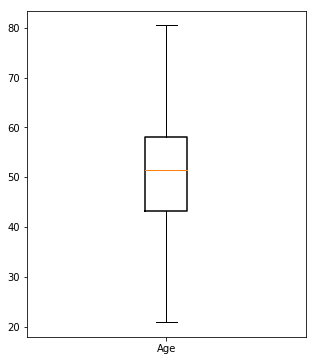

In [9]:
draw_boxplot(stats_age, label='Age')